In [1]:
from run_ib import RunIB
from enumerate_lexicons import get_random_lexicon
import enumerate_lexicons as el
import random
from ib import mi, information_plane
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stirling import stirling
import enumerate_lexicons
pd.options.display.max_rows = 250
import scipy
from helper_functions import *

In [75]:
# helper function: _ib (this includes custom initialization)
DEFAULT_NUM_ITER=10
def _ib(p_x, p_y_x, Z, gamma, init, num_iter=DEFAULT_NUM_ITER, temperature = 1):
    """ Find encoder q(Z|X) to minimize J = I[X:Z] - gamma * I[Y:Z].
    
    Input:
    p_x : Distribution on X, of shape X.
    p_y_x : Conditional distribution on Y given X, of shape X x Y.
    gamma : A non-negative scalar value.
    Z : Support size of Z.

    Output: 
    Conditional distribution on Z given X, of shape X x Z.

    """
    # Support size of X
    X = p_x.shape[-1]

    # Support size of Y
    Y = p_y_x.shape[-1]
    
    informativity = []
    complexity = []

    # Randomly initialize the conditional distribution q(z|x)
    q_z_x = init #scipy.special.softmax(np.random.randn(X, Z), -1) # shape X x Z
    p_y_x = p_y_x[:, None, :] # shape X x 1 x Y
    p_x = p_x[:, None] # shape X x 1
    
    informativity_temp, complexity_temp = information_plane(x.prior, x.prob_u_given_m, init)
    informativity.append(informativity_temp)
    complexity.append(complexity_temp)

    # Blahut-Arimoto iteration to find the minimizing q(z|x)
    for _ in range(num_iter):
        q_xz = p_x * q_z_x # Joint distribution q(x,z), shape X x Z
        q_z = q_xz.sum(axis=0, keepdims=True) # Marginal distribution q(z), shape 1 x Z
        q_y_z = ((q_xz / q_z)[:, :, None] * p_y_x).sum(axis=0, keepdims=True) # Conditional decoder distribution q(y|z), shape 1 x Z x Y
        d = ( 
            scipy.special.xlogy(p_y_x, p_y_x)
            - scipy.special.xlogy(p_y_x, q_y_z) # negative KL divergence -D[p(y|x) || q(y|z)]
        ).sum(axis=-1) # expected distortion over Y; shape X x Z
        q_z_x = scipy.special.softmax((np.log(q_z) - gamma*d)/temperature, axis=-1) # Conditional encoder distribution q(z|x) = 1/Z q(z) e^{-gamma*d}
        
        informativity_temp, complexity_temp = information_plane(x.prior, x.prob_u_given_m, q_z_x)
        informativity.append(informativity_temp)
        complexity.append(complexity_temp)

    return informativity, complexity

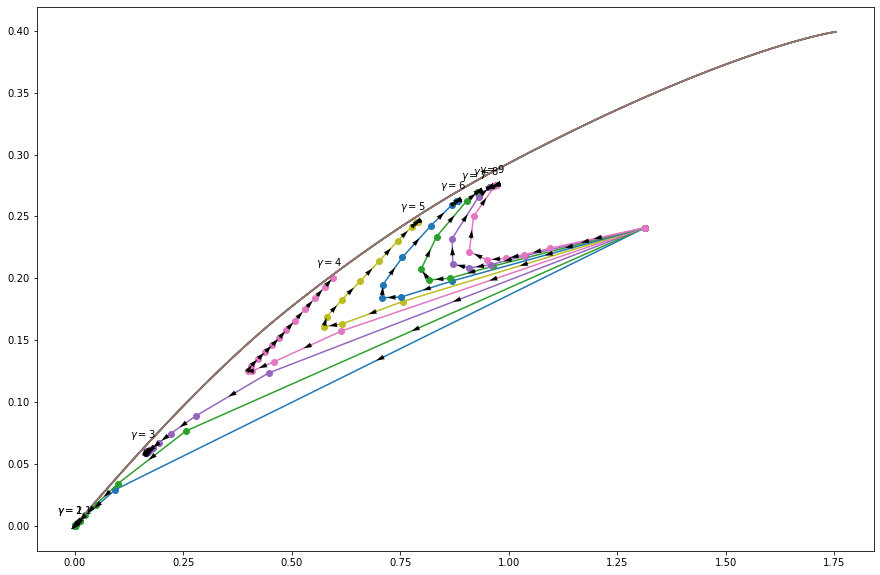

In [125]:
mu = 0.3
num_dists = 3
pgs_dists = [0,0.789,-1.315]
num_words = 9
num_meanings = num_dists * 3
gammas = [1.1,2,3,4,5,6,7, 8, 9]

fig, ax = plt.subplots(figsize = (15,10))

curve = pd.read_csv('sheets/ib_curve_non_deter_mu_0.3_pgs_0_0.789_-1.315num_dists_3.csv')
for gamma in gammas:
    np.random.seed(int(gamma))
    init = scipy.special.softmax(np.random.rand(num_meanings, num_words), axis = -1)
    #init = np.identity(num_words)
    #init[2] = np.array([0, 0, 0.2, 0.3, 0, 0, 0, 0.4, 0.1])
    init = np.array([[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]])

    x = RunIB(mu, gamma, num_dists, pgs_dists)
    p_m = x.prior
    p_u_m = x.prob_u_given_m
    informativity, complexity = _ib(p_m, p_u_m, num_words, gamma, init, num_iter = 15)

    u = np.diff(complexity)
    v = np.diff(informativity)

    pos_x = complexity[:-1] + u/2
    pos_y = informativity[:-1] + v/2
    norm = np.sqrt(u**2+v**2)

    ax.plot(complexity,informativity, marker="o")
    ax.plot(curve["complexity"], curve["informativity"])
    ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", scale = 100)
    ax.annotate(f'$\gamma=${gamma}',xy=(complexity[-1], informativity[-1]), xytext=(complexity[-1]-0.04, informativity[-1]+0.01))
    #plt.show()